<a href="https://colab.research.google.com/github/bhaskatripathi/TypeTruth/blob/main/TypeTruth_Collab_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Version 3 - At Sentence or paragraph level

In [29]:
import time
import requests
import numpy as np
import pandas as pd
from IPython.display import display
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

class ContentGeneratorChecker:
    def __init__(self, token):
        self.header = {
            'Accept': '*/*',
            'Accept-Language': 'en-US,en;q=0.9,hi;q=0.8',
            'Authorization': token,
            'Connection': 'keep-alive',
            'Content-Type': 'application/json',
            'Origin': 'https://platform.openai.com',
            'Referer': 'https://platform.openai.com/',
            'Sec-Fetch-Dest': 'empty',
            'Sec-Fetch-Mode': 'cors',
            'Sec-Fetch-Site': 'same-site',
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
            'sec-ch-ua': '"Not_A Brand";v="99", "Google Chrome";v="109", "Chromium";v="109"',
            'sec-ch-ua-mobile': '?0',
            'sec-ch-ua-platform': '"macOS"',
        }
        self.possible_classes = [
            'Very unlikely to be AI-generated',
            'Unlikely to be AI-generated',
            'Cannot determine if AI-written or human-written',
            'Possibly AI-generated',
            'Likely AI-generated',
        ]
        self.class_max = [10, 45, 90, 98, 99]

    def detect(self, text, all_probs=False):
        data = {
            'prompt': text + "».\n",
            'max_tokens': 1,
            'temperature': 1,
            'top_p': 1,
            'n': 1,
            'logprobs': 5,
            'stop': '\n',
            'stream': False,
            'model': 'model-detect-v2',
        }
        try:
            response = requests.post('https://api.openai.com/v1/completions', headers=self.header, json=data)
            response.raise_for_status()
        except requests.exceptions.HTTPError as err:
            if response.status_code == 401:
                return "Error: Invalid bearer token"
            else:
                return f"HTTP error occurred: {err}"

        if response.status_code == 200:
            choices = response.json()['choices'][0]
            logprobs = choices['logprobs']['top_logprobs'][0]
            probs = {key: round(100 * np.e ** value, 2) for key, value in logprobs.items()}
            key_prob = probs['"']
            if self.class_max[0] < key_prob < self.class_max[len(self.class_max) - 1]:
                val = max(i for i in self.class_max if i < key_prob)
                class_label = self.possible_classes[self.class_max.index(val)]
            elif self.class_max[0] > key_prob:
                class_label = self.possible_classes[0]
            else:
                class_label = self.possible_classes[len(self.possible_classes) - 1]
            top_prob = {'Class': class_label, 'AI-Generated Probability': key_prob}
            if all_probs:
                return probs, top_prob
            return top_prob
        return "Check prompt, Length of sentence it should be more than 1,000 characters"

class AIDetector:
    def __init__(self, token):
        self.bearer_token = token
        self.od = ContentGeneratorChecker(self.bearer_token)

    def human_or_ai(self, score):
        if score >= 90:
            human_prob = 100 - score
            return score, human_prob, f"{score:.2f}% of the Text generated by AI."
        elif score >= 70:
            human_prob = 100 - score
            return score, human_prob, f"{score:.2f}% of the Text generated by AI."
        elif 60 > score >= 50:
            human_prob = 100 - score
            return score, human_prob, "AI text written by Human or Human written text improved by AI."
        elif score >= 30:
            human_prob = 100 - score
            return score, human_prob, f"{human_prob:.2f}% Text written by human."
        else:
            human_prob = 100 - score
            return score, human_prob, f"{human_prob:.2f}% Text written by human."

    def detect1(self, text, split_type='sentence'):
        if split_type == 'sentence':
            chunks = text.split(". ")
        elif split_type == 'paragraph':
            chunks = re.split('\n+', text)
        else:
            return "Invalid split_type. Choose 'sentence' or 'paragraph'."

        chunk_list = []
        for chunk in chunks:
            time.sleep(1)  # Adda delay before each call
            ai_response = self.od.detect(chunk)
            if isinstance(ai_response, str):
                return ai_response
            else:
                ai_score, human_score, human_or_ai_confidence = self.human_or_ai(ai_response['AI-Generated Probability'])
                chunk_list.append((chunk, ai_score, human_score, human_or_ai_confidence))

        df = pd.DataFrame(chunk_list, columns=['Content', 'AI Generated Probability', 'Human Written Probability', 'AI Generated Confidence'])
        return df

    def detect(self, text, split_type='sentence', chunk_size=2):
        if split_type == 'sentence':
            chunks = text.split(". ")
        elif split_type == 'paragraph':
            chunks = re.split('\n+', text)
        else:
            return "Invalid split_type. Choose 'sentence' or 'paragraph'."

        grouped_chunks = [". ".join(chunks[i:i+chunk_size]) for i in range(0, len(chunks), chunk_size)]

        chunk_list = []
        for chunk in grouped_chunks:
            time.sleep(1)  # Add a delay before each call
            ai_response = self.od.detect(chunk)
            if isinstance(ai_response, str):
                return ai_response
            else:
                ai_score, human_score, human_or_ai_confidence = self.human_or_ai(ai_response['AI-Generated Probability'])
                chunk_list.append((chunk, ai_score, human_score, human_or_ai_confidence))

        df = pd.DataFrame(chunk_list, columns=['Content', 'AI Generated Probability', 'Human Written Probability', 'AI Generated Confidence'])
        return df




import seaborn as sns
import matplotlib.pyplot as plt

def plot_bar_chart(df):
    # Create a list of paragraph labels
    para_labels = [f"Paragraph {i+1}" for i in range(len(df))]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 3))
    bars = plt.bar(para_labels, df['AI Generated Probability'], color='skyblue')
    ax.bar_label(bars)

    plt.xlabel('Paragraphs')
    plt.ylabel('AI Generated Probability (%)')
    plt.title('AI Generated Probability Across Paragraphs')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_stacked_bar_chart(df):
    # Create a list of paragraph labels
    para_labels = [f"Paragraph {i+1}" for i in range(len(df))]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 3.5))

    bar1 = plt.bar(para_labels, df['AI Generated Probability'], color='skyblue')
    bar2 = plt.bar(para_labels, df['Human Written Probability'], bottom=df['AI Generated Probability'], color='salmon')

    ax.bar_label(bar1, label_type='center', color='black')
    ax.bar_label(bar2, label_type='center', color='black')

    plt.xlabel('Paragraphs')
    plt.ylabel('Probability (%)')
    plt.title('AI Generated and Human Written Probability Across Paragraphs')
    plt.xticks(rotation=45)
    plt.legend([bar1, bar2], ['AI Generated', 'Human Written'], bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

def plot_heatmap(df):
    # Replace full sentences with first two words followed by '...'
    print(type(df['Content']))
    df['Content'] = df['Content'].apply(lambda x: print(type(x)) or ' '.join(str(x).split()[:2]) + '...')


    # Transpose the dataframe to form a matrix for heatmap
    heatmap_data = df[['Content', 'AI Generated Probability', 'Human Written Probability']].set_index('Content').transpose()

    plt.figure(figsize=(15, 3))
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
    plt.title('Heatmap of AI Generated and Human Written Probability')
    plt.show()






AI Content Detection at Paragraph Level


,Content,AI Generated Probability,Human Written Probability,AI Generated Confidence
0,Here's a use case that combines Elasticsearch ...,52.12,47.88,AI text written by Human or Human written text...


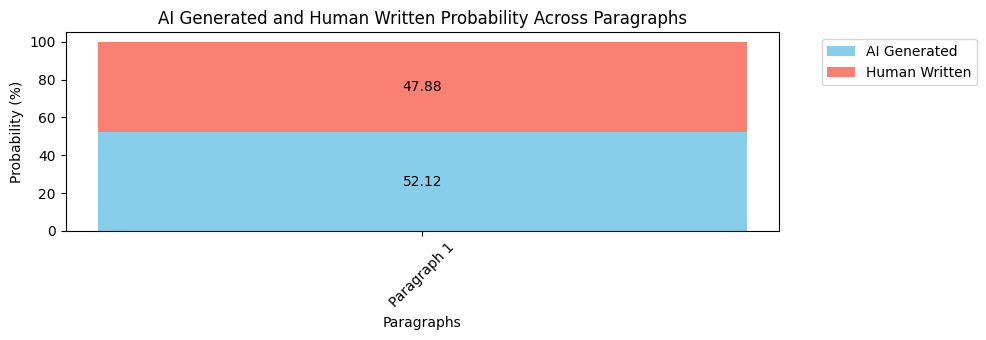

In [27]:
#Paragraph level AI Detection

if __name__ == '__main__':
    paragraph = """Here's a use case that combines Elasticsearch with Apache Beam for near real-time indexing. Elasticsearch is a distributed, open-source search and analytics engine for all types of data, including textual, numerical, geospatial, structured, and unstructured. Elasticsearch is built on Apache Lucene and was first released in 2010 by Elasticsearch (now known as Elastic). Elasticsearch is written in Java and released as open source under the terms of the Apache License. It's the most popular enterprise search engine.
    Apache Beam is an open-source, unified model for defining both batch and streaming data-parallel processing pipelines.
    Using one of the open source Beam SDKs, you build a program that defines the pipeline. The pipeline is then executed by one of Beam’s supported distributed processing back-ends, which include Apache Flink, Apache Samza, Apache Spark, and Google Cloud Dataflow."""

    API_KEY='Bearer sess-kNAm4E4SmTruiLihjW3ouIXRwY9De7QlEDKuYCiY' #please make sure you change the bearer Key as per the instructions in readme file

    detector = AIDetector(API_KEY)


    # Detect AI content at the paragraph level
    paragraph_df = detector.detect(paragraph, split_type='paragraph')
    print("\nAI Content Detection at Paragraph Level")
    display(paragraph_df)
    print("\n")
    # Plot the bar chart for paragraph level data
    plot_stacked_bar_chart(paragraph_df)

AI Content Detection at Sentence Level


,Content,AI Generated Probability,Human Written Probability,AI Generated Confidence
0,Here's a use case that combines Elasticsearch ...,95.75,4.25,95.75% of the Text generated by AI.
1,Elasticsearch is built on Apache Lucene and wa...,87.71,12.29,87.71% of the Text generated by AI.
2,It's the most popular enterprise search engine...,60.94,39.06,39.06% Text written by human.


<class 'pandas.core.series.Series'>
<class 'str'>
<class 'str'>
<class 'str'>


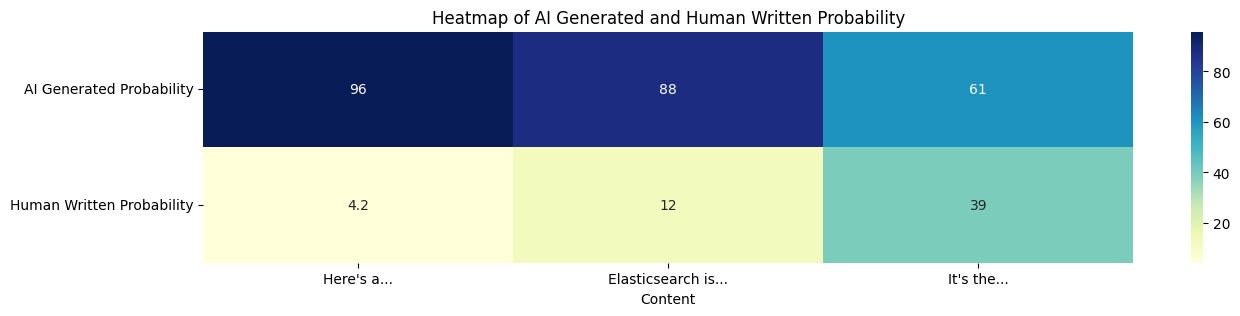

In [30]:

#Sentence Level AI Detection

if __name__ == '__main__':
    paragraph = """Here's a use case that combines Elasticsearch with Apache Beam for near real-time indexing. Elasticsearch is a distributed, open-source search and analytics engine for all types of data, including textual, numerical, geospatial, structured, and unstructured. Elasticsearch is built on Apache Lucene and was first released in 2010 by Elasticsearch (now known as Elastic). Elasticsearch is written in Java and released as open source under the terms of the Apache License. It's the most popular enterprise search engine.
    Apache Beam is an open-source, unified model for defining both batch and streaming data-parallel processing pipelines.
    Using one of the open source Beam SDKs, you build a program that defines the pipeline. The pipeline is then executed by one of Beam’s supported distributed processing back-ends, which include Apache Flink, Apache Samza, Apache Spark, and Google Cloud Dataflow."""


    API_KEY='Bearer sess-kNAm4E4SmTruiLihjW3ouIXRwY9De7QlEDKuYCiY'  #please make sure you change the bearer Key as per the instructions in readme file

    detector = AIDetector(API_KEY)

    # Detect AI content at the sentence level
    sentence_df = detector.detect(paragraph, split_type='sentence')
    print("AI Content Detection at Sentence Level")
    display(sentence_df)

    # Plot the bar chart for paragraph level data

        # Plot the heatmap for sentence level data
    if isinstance(sentence_df, pd.DataFrame):
      plot_heatmap(sentence_df)
    else:
      print("Error: ", sentence_df)


